In [2]:
!wget https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
!mkdir landscapes
!unzip landscapes_small.zip -d landscapes
!rm -r landscapes/__MACOSX

--2021-02-09 14:03:59--  https://github.com/ml5js/ml5-data-and-models/raw/master/datasets/images/landscapes/landscapes_small.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip [following]
--2021-02-09 14:03:59--  https://raw.githubusercontent.com/ml5js/ml5-data-and-models/master/datasets/images/landscapes/landscapes_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81935123 (78M) [application/zip]
Saving to: ‘landscapes_small.zip’

landscapes_small.zi 100%[===================>]  78.14M   184MB/s    in 0.4s    



#1. Split 80/20 :

In [3]:
from keras.preprocessing.image import ImageDataGenerator

input_dir = 'landscapes'

seed = 1
 
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
train_generator = datagen.flow_from_directory(input_dir,  seed=seed, subset='training', target_size=(256, 256),class_mode='categorical')
valid_generator = datagen.flow_from_directory(input_dir,  seed=seed, subset='validation', target_size=(256, 256),class_mode='categorical')


Found 3026 images belonging to 7 classes.
Found 755 images belonging to 7 classes.


In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple d'image :

(32, 256, 256, 3) (32, 7)
0.0 1.0


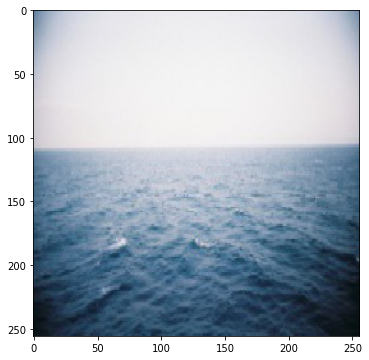

In [62]:
x,y = next(train_generator)
print(x.shape,y.shape)
print(x.min(), x.max())
plt.figure(figsize=(6,6))
idx = np.random.randint(0, len(x))
plt.imshow(np.squeeze(x[idx]));

#2. Construction d'un réseau de convolution :

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(lr=0.0001, decay=1e-6)

model_base = Sequential()

model_base.add(Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_base.add(MaxPooling2D((2, 2)))

model_base.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Dropout(.2))

model_base.add(Conv2D(32, (3, 3), activation='relu',padding="same"))
model_base.add(MaxPooling2D((2, 2)))

model_base.add(Flatten())
model_base.add(Dense(32, activation='relu'))
model_base.add(Dropout(.3))
model_base.add(Dense(7, activation='softmax'))

model_base.summary()

model_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 127, 127, 64)      73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 63, 63, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)      

In [65]:
history_base = model_base.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator)

Epoch 1/20
95/95 [==============================] - 12s 113ms/step - loss: 1.8034 - accuracy: 0.2849 - val_loss: 1.4143 - val_accuracy: 0.4755
Epoch 2/20
95/95 [==============================] - 11s 110ms/step - loss: 1.4689 - accuracy: 0.4206 - val_loss: 1.3039 - val_accuracy: 0.5457
Epoch 3/20
95/95 [==============================] - 11s 111ms/step - loss: 1.3145 - accuracy: 0.5120 - val_loss: 1.1295 - val_accuracy: 0.6265
Epoch 4/20
95/95 [==============================] - 11s 111ms/step - loss: 1.2210 - accuracy: 0.5628 - val_loss: 1.0582 - val_accuracy: 0.6450
Epoch 5/20
95/95 [==============================] - 11s 111ms/step - loss: 1.1609 - accuracy: 0.5798 - val_loss: 1.0688 - val_accuracy: 0.6371
Epoch 6/20
95/95 [==============================] - 11s 110ms/step - loss: 1.0852 - accuracy: 0.6142 - val_loss: 0.9854 - val_accuracy: 0.6821
Epoch 7/20
95/95 [==============================] - 10s 110ms/step - loss: 1.0924 - accuracy: 0.6115 - val_loss: 0.9914 - val_accuracy: 0.6675

# 3. avec Data Augmentation :


In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenting_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of total height)
    height_shift_range=0.2,# randomly shift images vertically (fraction of total height)
    shear_range=0.2,# set range for random shear
    zoom_range=0.2,# set range for random zoom
    horizontal_flip=True,# randomly flip images
    fill_mode='nearest', # set mode for filling points outside the input boundaries
    validation_split=.2
)

train_generator_aug = augmenting_datagen.flow_from_directory(input_dir,  seed=seed, subset='training', target_size=(256, 256),class_mode='categorical')
valid_generator_aug = augmenting_datagen.flow_from_directory(input_dir,  seed=seed, subset='validation', target_size=(256, 256),class_mode='categorical')

Found 3026 images belonging to 7 classes.
Found 755 images belonging to 7 classes.


In [54]:
opt = RMSprop(lr=0.0001, decay=1e-6)

model_aug = Sequential()

model_aug.add(Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_aug.add(MaxPooling2D((2, 2)))

model_aug.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model_aug.add(MaxPooling2D((2, 2)))
model_aug.add(Dropout(.2))

model_aug.add(Conv2D(32, (3, 3), activation='relu',padding="same"))
model_aug.add(MaxPooling2D((2, 2)))

model_aug.add(Flatten())
model_aug.add(Dense(32, activation='relu'))
model_aug.add(Dropout(.3))
model_aug.add(Dense(7, activation='softmax'))

model_aug.summary()

model_aug.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 127, 127, 64)      73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 63, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)      

In [56]:
history_aug = model_aug.fit(train_generator_aug,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator)

Epoch 1/20
95/95 [==============================] - 52s 541ms/step - loss: 1.8349 - accuracy: 0.2734 - val_loss: 1.5208 - val_accuracy: 0.4291
Epoch 2/20
95/95 [==============================] - 51s 540ms/step - loss: 1.5803 - accuracy: 0.3685 - val_loss: 1.3906 - val_accuracy: 0.4901
Epoch 3/20
95/95 [==============================] - 51s 541ms/step - loss: 1.4531 - accuracy: 0.4241 - val_loss: 1.1993 - val_accuracy: 0.5960
Epoch 4/20
95/95 [==============================] - 51s 538ms/step - loss: 1.3736 - accuracy: 0.4765 - val_loss: 1.1685 - val_accuracy: 0.6212
Epoch 5/20
95/95 [==============================] - 51s 538ms/step - loss: 1.3564 - accuracy: 0.4714 - val_loss: 1.1319 - val_accuracy: 0.6344
Epoch 6/20
95/95 [==============================] - 51s 537ms/step - loss: 1.2933 - accuracy: 0.5155 - val_loss: 1.0763 - val_accuracy: 0.6530
Epoch 7/20
95/95 [==============================] - 51s 535ms/step - loss: 1.2565 - accuracy: 0.5206 - val_loss: 1.0616 - val_accuracy: 0.6411

Commentaire : on obtient de moins bon résultats que sans Data-augmentation

# 4. Utilisation d'un réseau pré-entraîné :

In [8]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

58892288/58889256 [==============================] - 0s 0us/step


dans un premier temps on gêle les poids du réseau pré-entraîné :

In [38]:
modelPT = Sequential()
modelPT.add(conv_base)
modelPT.add(Flatten())
modelPT.add(Dropout(.4))
modelPT.add(Dense(256, activation='relu', name='features'))
modelPT.add(Dropout(.4))
modelPT.add(Dense(7, activation='sigmoid'))

modelPT.summary()
modelPT.compile(optimizer=RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
conv_base.trainable = False

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32768)             0         
_________________________________________________________________
features (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1799      
Total params: 23,105,351
Trainable params: 8,390,663
Non-trainable params: 14,714,688
__________________________________

In [39]:
history_PT = modelPT.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator)

Epoch 1/20
95/95 [==============================] - 12s 119ms/step - loss: 1.8935 - accuracy: 0.2907 - val_loss: 0.9057 - val_accuracy: 0.8013
Epoch 2/20
95/95 [==============================] - 11s 116ms/step - loss: 1.0624 - accuracy: 0.6267 - val_loss: 0.5958 - val_accuracy: 0.8477
Epoch 3/20
95/95 [==============================] - 11s 116ms/step - loss: 0.8157 - accuracy: 0.7252 - val_loss: 0.4672 - val_accuracy: 0.8755
Epoch 4/20
95/95 [==============================] - 11s 115ms/step - loss: 0.6694 - accuracy: 0.7671 - val_loss: 0.4299 - val_accuracy: 0.8596
Epoch 5/20
95/95 [==============================] - 11s 116ms/step - loss: 0.6126 - accuracy: 0.7958 - val_loss: 0.3775 - val_accuracy: 0.8821
Epoch 6/20
95/95 [==============================] - 11s 115ms/step - loss: 0.5137 - accuracy: 0.8316 - val_loss: 0.3697 - val_accuracy: 0.8874
Epoch 7/20
95/95 [==============================] - 11s 116ms/step - loss: 0.4776 - accuracy: 0.8358 - val_loss: 0.3631 - val_accuracy: 0.8848

Le même modèle en faisant du fine-tuning sur les 3 dernières couches de convolution du pretrained-model :

In [40]:
modelPTFT = Sequential()
modelPTFT.add(conv_base)
modelPTFT.add(Flatten())
modelPTFT.add(Dropout(.4))
modelPTFT.add(Dense(256, activation='relu', name='features'))
modelPTFT.add(Dropout(.4))
modelPTFT.add(Dense(7, activation='sigmoid'))

modelPTFT.summary()
modelPTFT.compile(optimizer=RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
conv_base.trainable = False

for layer in conv_base.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3'] :
        layer.trainable = True

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32768)             0         
_________________________________________________________________
features (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 1799      
Total params: 23,105,351
Trainable params: 8,390,663
Non-trainable params: 14,714,688
__________________________________

In [41]:
history_PTFT = modelPTFT.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator)

Epoch 1/20
95/95 [==============================] - 12s 121ms/step - loss: 1.8488 - accuracy: 0.3052 - val_loss: 0.9221 - val_accuracy: 0.7060
Epoch 2/20
95/95 [==============================] - 11s 116ms/step - loss: 1.1125 - accuracy: 0.6250 - val_loss: 0.5969 - val_accuracy: 0.8397
Epoch 3/20
95/95 [==============================] - 11s 116ms/step - loss: 0.8091 - accuracy: 0.7125 - val_loss: 0.4634 - val_accuracy: 0.8662
Epoch 4/20
95/95 [==============================] - 11s 116ms/step - loss: 0.6537 - accuracy: 0.7720 - val_loss: 0.4163 - val_accuracy: 0.8781
Epoch 5/20
95/95 [==============================] - 11s 116ms/step - loss: 0.5837 - accuracy: 0.7966 - val_loss: 0.4012 - val_accuracy: 0.8728
Epoch 6/20
95/95 [==============================] - 11s 117ms/step - loss: 0.5407 - accuracy: 0.8209 - val_loss: 0.3665 - val_accuracy: 0.8914
Epoch 7/20
95/95 [==============================] - 11s 117ms/step - loss: 0.4509 - accuracy: 0.8410 - val_loss: 0.3517 - val_accuracy: 0.8887

Les performances sont du même ordre, peut-être faudrait-il passer un peu plus de temps pour les améliorer.

# 5. Comparaison des différents modèles :

24/24 [==============================] - 2s 94ms/step - loss: 0.2920 - accuracy: 0.9020


Text(0.5, 1.0, 'Accuracy')

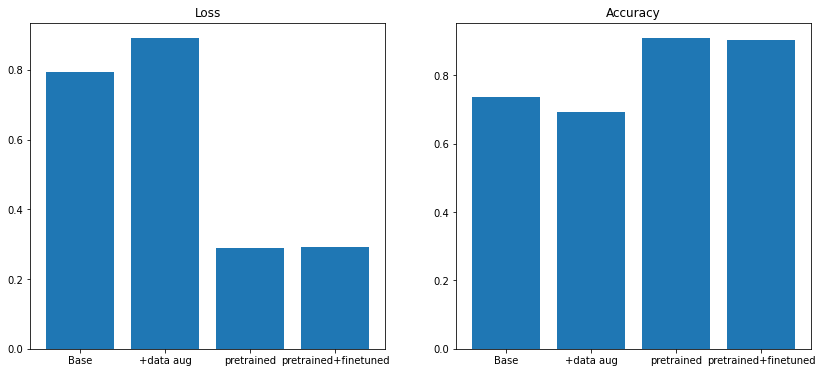

In [82]:
models = [model_base,
          model_aug,
          modelPT,
          modelPTFT]

names = ['Base','+data aug','pretrained','pretrained+finetuned']
losses=[]
accuracys=[]
for model in models :
  loss,accuracy = model.evaluate(valid_generator)
  losses.append(loss)
  accuracys.append(accuracy)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6))

ax[0].bar(names,losses)
ax[0].set_title('Loss')
ax[1].bar(names,accuracys);
ax[1].set_title('Accuracy') 

En l'état, le meilleur modèle est le pretrained model sans fine-tuning.

#6. Erreur de prédictions

On s'intéresse aux erreurs de prédictions de notre meilleur modèle.

In [102]:
xs,ys,predictions = [],[], []
for i in range(5):
  x,y  = next(valid_generator)
  xs.append(x)
  ys.append(y)
  pred = modelPT.predict(x)
  predictions.append(pred)

xs = np.vstack(xs)
ys = np.argmax(np.vstack(ys),axis = 1)
predictions = np.argmax(np.vstack(predictions),axis=1)

In [110]:
mistakes = np.where(predictions != ys)[0][:10]
print(mistakes)

[ 0 11 20 27 34 46 54 64 73 88]


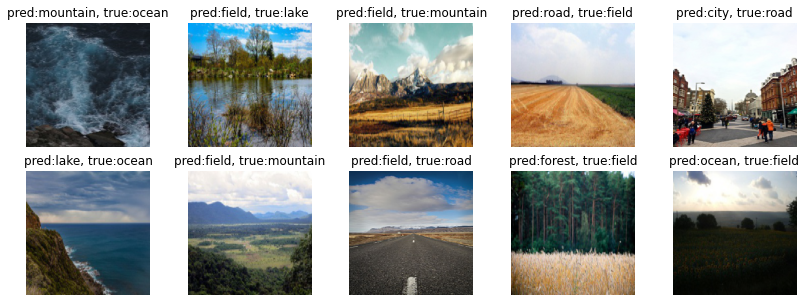

In [117]:
plt.figure(figsize=(14, 5))
class_names = ['city','field','forest','lake','mountain','ocean','road']
for i, index in enumerate(mistakes):
  plt.subplot(2, 5, i + 1)
  plt.title(f'pred:{class_names[predictions[index]]}, true:{class_names[ys[index]]}')
  plt.imshow(xs[index])
  plt.axis('off')

Certaines fois les labels sont ambigus. Néanmoins, sur des images sans ambiguités, le modèle fait encore des erreurs.

# 7. Extraction des features produites par le pretrained-model :

In [83]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

def extract_features(generator, sample_count):
    batch_size = 32
    features = np.zeros(shape=(sample_count, 8, 8, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_generator, 320*7)
test_features, test_labels = extract_features(valid_generator, 320*2)


# Visualisation des features à l'aide d'une t-SNE :

In [84]:
train_features = np.reshape(train_features, (320*7, 8 * 8 * 512))
test_features = np.reshape(test_features, (320*2  , 8 * 8 * 512))

In [85]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_pca = PCA(n_components=50).fit_transform(train_features)
X_tsne =TSNE().fit_transform(X_pca)

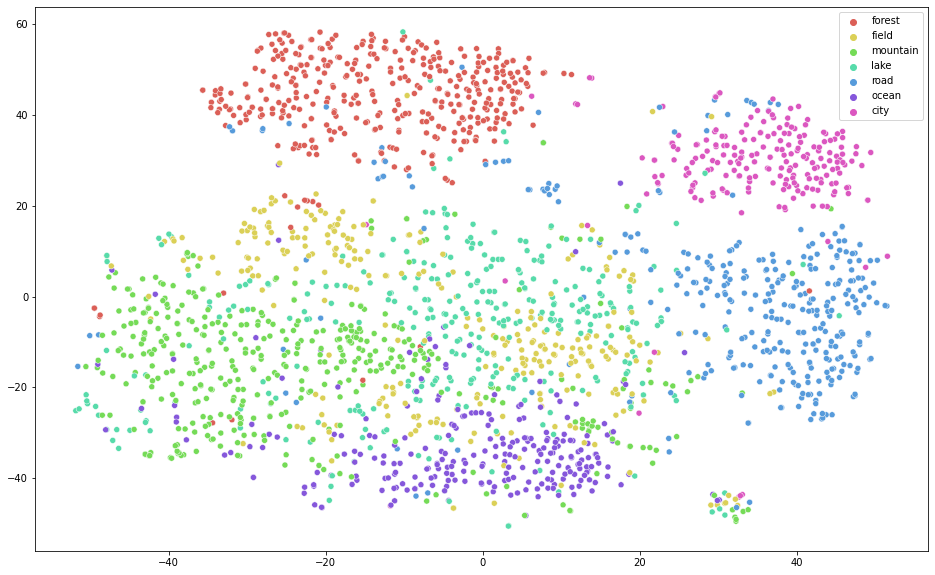

In [138]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=[class_names[i] for i in train_labels.astype(int)],
    palette=sns.color_palette("hls", 7),
    legend="full",
);

On voit une bonne séparation des données sur seulement deux dimensions

# 8. 4 images proches

In [26]:
datagen2 = ImageDataGenerator(rescale=1/255.0)
generator = datagen2.flow_from_directory(input_dir,seed=seed,target_size=(256,256),class_mode ='categorical')

from tensorflow.keras.applications import VGG16
import numpy as np

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))
generator.reset()
x,y = generator[6]
rdm_img = x[9:10]
rdm_img_features = conv_base.predict(rdm_img)

d1, d2, d3 = np.inf, np.inf, np.inf  #(d1 < d2 < d3)
img1,img2,img3 = None,None,None
i = 0
while i < 3781:
  x,y = next(generator)
  i += len(x)
  x_features = conv_base.predict(x)

  c = np.vstack(len(x_features)*[rdm_img_features])
  c = np.reshape(c,(len(c),8*8*512))
  x_features = np.reshape(x_features,(len(x),8*8*512))
  dist = np.linalg.norm(c - x_features,axis=1)
  dist = np.where(dist > 0.01, dist, np.inf)  # en théorie c'est 0 mais après calcul il vaut mieux mettre 10**-2 sinon on retombe sur la même image
  idx = (dist).argsort()[:3] #index des 3 plus petites distances non nulles
  distsmins = dist[idx]
  for j, d in enumerate(distsmins):
    if d < max(d1,d2,d3):
      if d < d1 :
        d3 = d2
        d2 = d1
        d1 = d
        img3 = img2
        img2 = img1
        img1 = x[idx[j]]
      elif d < d2:
        d3 = d2
        d2 = d
        img3 = img2
        img2 = x[idx[j]]
      else:
        d3 = d
        img3 = x[idx[j]]
      print(d1,d2,d3)

Found 3781 images belonging to 7 classes.
44.36177 inf inf
44.36177 44.50094 inf
44.36177 44.50094 44.998398
43.126762 44.36177 44.50094
43.126762 43.17325 44.36177
42.918568 43.126762 43.17325
42.918568 43.056374 43.126762
41.933968 42.918568 43.056374
41.933968 42.287872 42.918568
41.270958 41.933968 42.287872
41.270958 41.933968 42.103737
41.270958 41.933968 41.959362
41.270958 41.787975 41.933968
41.270958 41.708946 41.787975
41.270958 41.57612 41.708946
41.214184 41.270958 41.57612
40.967583 41.214184 41.270958
40.967583 41.214184 41.247124
39.26648 40.967583 41.214184


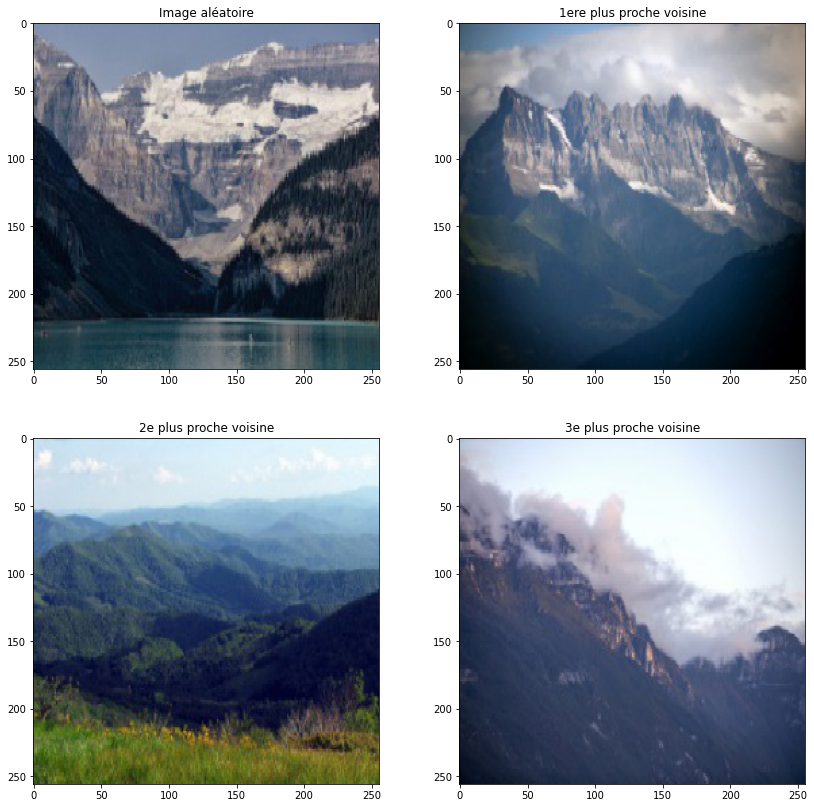

In [27]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,14))

ax[0, 0].imshow(rdm_img[0])
ax[0, 0].set_title('Image aléatoire')
ax[0,1].imshow(img1)
ax[0,1].set_title('1ere plus proche voisine') 
ax[1,0].imshow(img2)
ax[1,0].set_title('2e plus proche voisine') 
ax[1,1].imshow(img3)
ax[1,1].set_title('3e plus proche voisine');

Cela fait parfaitement sens !